# CIFAR-100: DropBlock vs SpatialDropout2d (Aynı Model İçinde Karşılaştırma)

Bu notebook:
- Aynı backbone ✅  
- Aynı eğitim ayarları ✅  
- Sadece regularization modu değişiyor:  
  - `none` (baseline)  
  - `spatial_dropout`  
  - `dropblock`  
  - `dropblock+spatial_dropout`  

> CIFAR-100 indirmek için internet gerekir (torchvision). GPU önerilir.


In [10]:
    
import os, random, time
from dataclasses import dataclass
from typing import Optional, Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader


In [11]:
# === 1) Seed / Device ===
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 2) Modüller (Yorumlar Temiz)

- `DropBlock2D_Scheduled` 
- `SpatialDropout2d` 

In [12]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class DropBlock2D_Scheduled(nn.Module):
    def __init__(self, max_drop_prob=0.1, block_size=7, total_steps=10_000):
        super().__init__()
        self.max_drop_prob = float(max_drop_prob)
        self.block_size = int(block_size)
        self.total_steps = int(total_steps)
        self.register_buffer("step", torch.zeros((), dtype=torch.long))

    def _current_drop_prob(self):
        s = int(self.step.item())
        t = min(max(s / max(1, self.total_steps), 0.0), 1.0)
        return self.max_drop_prob * t

    def forward(self, x):
        if self.training:
            self.step += 1

        drop_prob = self._current_drop_prob()
        if (not self.training) or drop_prob <= 0.0:
            return x

        if x.dim() != 4:
            raise ValueError(f"DropBlock 4D tensor bekler (N,C,H,W). Geldi: {x.shape}")

        n, c, h, w = x.shape
        bs = min(self.block_size, h, w)
        if bs < 1:
            return x

        valid_h = h - bs + 1
        valid_w = w - bs + 1
        block_area = bs * bs

        gamma = drop_prob * (h * w) / (block_area * valid_h * valid_w)

        center_mask = (torch.rand((n, c, valid_h, valid_w), device=x.device) < gamma).float()

        pad_h = (bs - 1) // 2
        pad_w = (bs - 1) // 2
        center_mask = F.pad(center_mask, (pad_w, pad_w, pad_h, pad_h))

        block_mask = F.max_pool2d(center_mask, kernel_size=bs, stride=1, padding=bs // 2)
        block_mask = block_mask[:, :, :h, :w]

        mask = 1.0 - block_mask
        keep_prob = mask.mean().clamp(min=1e-6)
        return x * mask / keep_prob


In [13]:
import torch
import torch.nn as nn

class SpatialDropout2d(nn.Module):
    def __init__(self, p: float = 0.1):
        super().__init__()
        if not (0.0 <= p < 1.0):
            raise ValueError("p 0 ve 1 arasında olmalı")
        self.p = float(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if (not self.training) or (self.p == 0.0):
            return x

        q = 1.0 - self.p
        mask = torch.empty(
            (x.size(0), x.size(1), 1, 1),
            device=x.device,
            dtype=x.dtype
        ).bernoulli_(q)

        return x * mask / q


## 3) Aynı Model: CIFARResNet (DropBlock / SpatialDropout seçenekli)

Uygulama noktası:
- Residual branch içinde `act` sonrası (feature map üzerinde)
- Sıra: `act -> (dropblock) -> (spatial_dropout)` (ikisi birlikte seçilirse)


In [14]:

class ConvBNAct(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1, act="relu"):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        if act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "silu":
            self.act = nn.SiLU(inplace=True)
        else:
            raise ValueError("act must be 'relu' or 'silu'")

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(
        self,
        cin: int,
        cout: int,
        stride: int = 1,
        act: str = "relu",
        dropblock: Optional[nn.Module] = None,
        spatial: Optional[nn.Module] = None,
    ):
        super().__init__()
        self.conv1 = ConvBNAct(cin, cout, k=3, s=stride, p=1, act=act)
        self.conv2 = nn.Sequential(
            nn.Conv2d(cout, cout, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(cout),
        )
        self.act = nn.ReLU(inplace=True) if act == "relu" else nn.SiLU(inplace=True)

        self.dropblock = dropblock
        self.spatial = spatial

        if cin != cout or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(cin, cout, 1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(cout),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.act(out)

        if self.dropblock is not None:
            out = self.dropblock(out)
        if self.spatial is not None:
            out = self.spatial(out)

        return out + self.shortcut(x)

class CIFARResNet(nn.Module):
    def __init__(
        self,
        num_classes: int = 100,
        act: str = "relu",
        mode: Literal["none","spatial_dropout","dropblock","dropblock+spatial_dropout"] = "none",
        dropblock_max: float = 0.1,
        dropblock_size: int = 7,
        dropblock_steps: int = 10_000,
        spatial_p: float = 0.1,
    ):
        super().__init__()
        self.mode = mode

        self.stem = nn.Sequential(
            ConvBNAct(3, 64, k=3, s=1, p=1, act=act),
            ConvBNAct(64, 64, k=3, s=1, p=1, act=act),
        )

        blocks_per_stage = [3, 3, 3]

        def make_stage(cin, cout, nblocks, stride):
            layers = []
            for i in range(nblocks):
                block_stride = stride if i == 0 else 1

                use_db = (mode in ["dropblock", "dropblock+spatial_dropout"])
                use_sp = (mode in ["spatial_dropout", "dropblock+spatial_dropout"])

                db = DropBlock2D_Scheduled(dropblock_max, dropblock_size, dropblock_steps) if use_db else None
                sp = SpatialDropout2d(spatial_p) if use_sp else None

                layers.append(ResidualBlock(cin if i==0 else cout, cout, block_stride, act=act, dropblock=db, spatial=sp))
            return nn.Sequential(*layers)

        self.stage1 = make_stage(64, 64, blocks_per_stage[0], stride=1)
        self.stage2 = make_stage(64, 128, blocks_per_stage[1], stride=2)
        self.stage3 = make_stage(128, 256, blocks_per_stage[2], stride=2)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)


## 4) CIFAR-100 DataLoaders


In [15]:

@dataclass
class DataCfg:
    root: str = "./data"
    batch_size: int = 128
    num_workers: int = 2

data_cfg = DataCfg()

mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

train_ds = torchvision.datasets.CIFAR100(root=data_cfg.root, train=True, download=True, transform=train_tf)
test_ds  = torchvision.datasets.CIFAR100(root=data_cfg.root, train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=data_cfg.batch_size, shuffle=True, num_workers=data_cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=data_cfg.batch_size, shuffle=False, num_workers=data_cfg.num_workers, pin_memory=True)

len(train_ds), len(test_ds)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## 5) Train / Eval


In [16]:

@torch.no_grad()
def accuracy_top1(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if scaler is None:
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()
        else:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = F.cross_entropy(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits.detach(), y) * bs
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n


## 6) Deney Runner (4 mod)


In [17]:

import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class TrainCfg:
    epochs: int = 20
    lr: float = 0.1
    weight_decay: float = 5e-4
    momentum: float = 0.9
    use_amp: bool = True

train_cfg = TrainCfg(epochs=12)

def run_experiment(mode: str, seed: int = 42) -> pd.DataFrame:
    seed_everything(seed)
    model = CIFARResNet(
        num_classes=100,
        act="relu",
        mode=mode,
        dropblock_max=0.1,
        dropblock_size=7,
        dropblock_steps=10_000,
        spatial_p=0.1,
    ).to(device)

    optimizer = optim.SGD(model.parameters(), lr=train_cfg.lr, momentum=train_cfg.momentum, weight_decay=train_cfg.weight_decay, nesterov=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_cfg.epochs)

    scaler = torch.cuda.amp.GradScaler() if (train_cfg.use_amp and device == "cuda") else None

    rows = []
    for epoch in range(1, train_cfg.epochs + 1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scaler)
        te_loss, te_acc = eval_one_epoch(model, test_loader)
        scheduler.step()

        rows.append({
            "mode": mode,
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "test_loss": te_loss,
            "test_acc": te_acc,
            "lr": scheduler.get_last_lr()[0],
            "sec": time.time() - t0,
        })
        print(f"[{mode}] epoch {epoch:02d}/{train_cfg.epochs} | tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | te_loss={te_loss:.4f} te_acc={te_acc:.4f} | lr={rows[-1]['lr']:.5f}")
    return pd.DataFrame(rows)

modes = ["none", "spatial_dropout", "dropblock", "dropblock+spatial_dropout"]


In [18]:

all_df = []
for m in modes:
    df = run_experiment(m, seed=42)
    all_df.append(df)

results = pd.concat(all_df, ignore_index=True)
results.head()

C:\Users\hdgn5\AppData\Local\Temp\ipykernel_12476\4236223370.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (train_cfg.use_amp and device == "cuda") else None
C:\Users\hdgn5\AppData\Local\Temp\ipykernel_12476\1933026592.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[none] epoch 01/12 | tr_loss=3.9106 tr_acc=0.1039 | te_loss=3.6385 te_acc=0.1521 | lr=0.09830
[none] epoch 02/12 | tr_loss=3.1912 tr_acc=0.2155 | te_loss=3.3382 te_acc=0.2035 | lr=0.09330
[none] epoch 03/12 | tr_loss=2.6512 tr_acc=0.3168 | te_loss=2.6301 te_acc=0.3186 | lr=0.08536
[none] epoch 04/12 | tr_loss=2.2590 tr_acc=0.3997 | te_loss=2.5663 te_acc=0.3700 | lr=0.07500
[none] epoch 05/12 | tr_loss=1.9823 tr_acc=0.4610 | te_loss=2.0990 te_acc=0.4403 | lr=0.06294
[none] epoch 06/12 | tr_loss=1.7548 tr_acc=0.5151 | te_loss=2.5252 te_acc=0.3796 | lr=0.05000
[none] epoch 07/12 | tr_loss=1.5587 tr_acc=0.5623 | te_loss=1.6586 te_acc=0.5385 | lr=0.03706
[none] epoch 08/12 | tr_loss=1.3763 tr_acc=0.6101 | te_loss=1.5663 te_acc=0.5663 | lr=0.02500
[none] epoch 09/12 | tr_loss=1.1998 tr_acc=0.6554 | te_loss=1.4325 te_acc=0.5954 | lr=0.01464
[none] epoch 10/12 | tr_loss=1.0214 tr_acc=0.7052 | te_loss=1.2794 te_acc=0.6364 | lr=0.00670
[none] epoch 11/12 | tr_loss=0.8645 tr_acc=0.7488 | te_loss=

,mode,epoch,train_loss,train_acc,test_loss,test_acc,lr,sec
0,none,1,3.910557,0.10388,3.638496,0.1521,0.098296,68.113795
1,none,2,3.191153,0.21554,3.338230,0.2035,0.093301,71.668723
2,none,3,2.651240,0.31678,2.630106,0.3186,0.085355,58.840038
3,none,4,2.258977,0.39968,2.566328,0.3700,0.075000,64.020364
4,none,5,1.982257,0.46096,2.099034,0.4403,0.062941,65.531838


In [19]:
summary = (results.sort_values(['mode','epoch'])
           .groupby('mode', as_index=False)
           .tail(1)
           .sort_values('test_acc', ascending=False))
summary

,mode,epoch,train_loss,train_acc,test_loss,test_acc,lr,sec
35,dropblock,12,0.887767,0.74324,1.131188,0.6733,0.0,53.782063
11,none,12,0.762384,0.78108,1.147377,0.6718,0.0,40.728929
47,dropblock+spatial_dropout,12,1.084171,0.68700,1.212337,0.6512,0.0,57.564766
23,spatial_dropout,12,1.107944,0.68058,1.265141,0.6403,0.0,42.268669


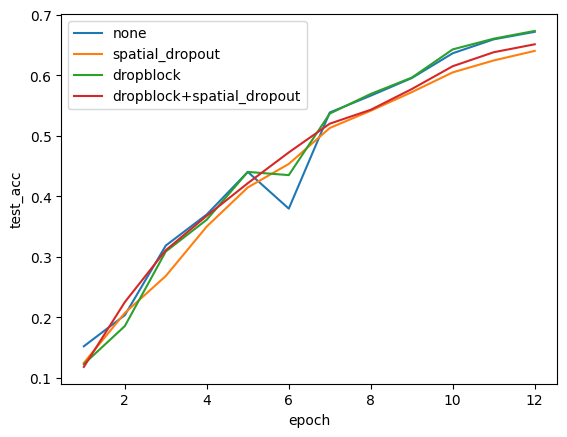

In [20]:
plt.figure()
for m in modes:
    sub = results[results['mode'] == m]
    plt.plot(sub['epoch'], sub['test_acc'], label=m)
plt.xlabel("epoch")
plt.ylabel("test_acc")
plt.legend()
plt.show()

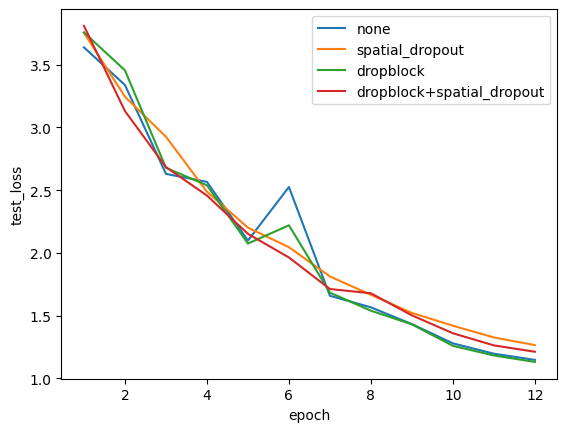

In [21]:
plt.figure()
for m in modes:
    sub = results[results['mode'] == m]
    plt.plot(sub['epoch'], sub['test_loss'], label=m)
plt.xlabel("epoch")
plt.ylabel("test_loss")
plt.legend()
plt.show()